<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Question-3a" data-toc-modified-id="Question-3a-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Question 3a</a></span></li><li><span><a href="#Question-3b" data-toc-modified-id="Question-3b-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Question 3b</a></span></li><li><span><a href="#For-Fun" data-toc-modified-id="For-Fun-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>For Fun</a></span><ul class="toc-item"><li><span><a href="#Word-Embeddings-with-SpaCy" data-toc-modified-id="Word-Embeddings-with-SpaCy-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Word Embeddings with SpaCy</a></span></li><li><span><a href="#t-SNE" data-toc-modified-id="t-SNE-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>t-SNE</a></span></li></ul></li></ul></div>

# Libraries

Import required libraries:

In [1]:
import pandas as pd
import retinasdk
import numpy as np
from pathlib import Path
import re
from sklearn.cluster import DBSCAN, KMeans
from sklearn import manifold
from sklearn import metrics
from nltk import word_tokenize

# Question 3a

**Question**
![](./images/question3a.png)
**Solution**

Read the output of Q2:

In [2]:
q2_df = pd.read_csv('../datasets/output_from_Q2.csv')
q2_df.head(3)

,Job Title,Position Duration,Position Location,Job Description,Job Responsibilities,Required Qualifications,Remuneration,Application Deadline,About Company,Clean Job Responsibilities,Duration
0,Chief Financial Officer,NaN,"Yerevan, Armenia",AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...,"To perform this job successfully, an\r\r\nindi...",NaN,26 January 2004,NaN,- supervise financial management administrativ...,this is a custom message
1,Full-time Community Connections Intern (paid i...,3 months,"IREX Armenia Main Office; Yerevan, Armenia",IREX currently seeks to fill the position of a...,- Presenting the CC program to interested part...,- Bachelor's Degree; Master's is preferred;\r\...,Commensurate with experience.,12 January 2004,The International Research & Exchanges Board (...,- present cc program interest party ; - assist...,3 months
2,Country Coordinator,Renewable annual contract,"Yerevan, Armenia",Public outreach and strengthening of a growing...,- Working with the Country Director to provide...,"- Degree in environmentally related field, or ...",Salary commensurate with experience.,20 January 2004,The Caucasus Environmental NGO Network is a\r\...,- work country director provide environmental ...,Renewable annual contract\r\r\nPOSITION


Setup to use [Cortical.io](https://www.cortical.io/)'s SDR as the word embeddings:

In [3]:
api_key = 'e098e740-1fdd-11e7-b22d-93a4ae922ff1'
liteClient = retinasdk.LiteClient(api_key)

Build a Series containing the fields to be used as input:

In [4]:
feature_columns = ['Job Title', 'Job Description', 'Job Responsibilities']
input_text = q2_df[feature_columns] \
    .fillna('') \
    .apply(lambda columns: ' '.join(columns), axis=1)\
    .apply(lambda text: 'no text' if text.strip() == '' else text)\
    .apply(lambda text: re.sub('[^A-Za-z]', ' ', text))

Get the semantic fingerprints and save the intemediary results:

In [5]:
%%time
fingerprints_file = '../datasets/output_from_Q2_with_fingerprints.csv'

if not Path(fingerprints_file).exists():
    q2_df['finger_print'] = input_text.apply(lambda text: liteClient.getFingerprint(text))
    q2_df.to_csv(fingerprints_file, index = False)

Wall time: 0 ns


Convert all semantic fingerprints into its vector representation and drop duplicate feature columns:

In [6]:
%%time
def fingerprint_to_vector(fingerprint):
    fingerprint = eval(fingerprint)
    vec = np.zeros(16384)
    vec[fingerprint] = 1
    
    return vec

q2_df = pd.read_csv(fingerprints_file)

q2_df['finger_print'] = q2_df['finger_print'].apply(fingerprint_to_vector)
q2_df = q2_df.drop_duplicates(['Job Title', 'Job Description', 'Job Responsibilities'])

Wall time: 25 s


Drop job ads whose cleaned job responsibilities contain the same words:

In [7]:
q2_df['Extra Clean Job Responsibilities'] = q2_df['Clean Job Responsibilities']\
    .fillna('')\
    .apply(lambda text: [token for token in word_tokenize(text) if token.isalpha()])\
    .apply(lambda token_list: ' '.join(token_list))

q2_df = q2_df.drop_duplicates(['Extra Clean Job Responsibilities'])

Build the feature matrix:

In [8]:
feature_matrix = np.stack(q2_df['finger_print'].values)

Apply the K-means clustering algorithm on the feature matrix:

In [9]:
%%time
db = KMeans(init='k-means++', n_clusters=2, n_init=10, n_jobs=-1).fit(feature_matrix)

Wall time: 2min 18s


Assess quality of the clustering algorithm's groups:

In [10]:
%%time
metrics.calinski_harabaz_score(feature_matrix, db.labels_)

Wall time: 6.99 s


475.60459820839395

Note: In my experiments, the evaluation metric is highest when the number of clusters is 2.

Assign group labels to each job ad:

In [11]:
q2_df['label'] = db.labels_

# Question 3b

**Question**
![](./images/question3b.png)

**Solution**

Count the number of job ads in each group:

In [12]:
group_summary = q2_df\
 .query('label != -1')\
 .groupby('label')\
 .size()\
 .to_frame('n')\
 .sort_values('n', ascending=False)

group_summary

,n
label,
1,9934
0,3234


Display some members from each group:

In [13]:
q2_df\
 .query('label == @group_summary.index[0]')\
 .sample(5)

,Job Title,Position Duration,Position Location,Job Description,Job Responsibilities,Required Qualifications,Remuneration,Application Deadline,About Company,Clean Job Responsibilities,Duration,finger_print,Extra Clean Job Responsibilities,label
17392,Head of Master's Program with National-Researc...,Long term,"Yerevan, Armenia",Russian-Armenian (Slavonic) University is look...,- Lead administrative and operational implemen...,- PhD and at least 3 years of relevant experie...,NaN,15 April 2015,NaN,- lead administrative operational implementati...,Long term,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",lead administrative operational implementation...,1
2910,Contract Officer,NaN,"Yerevan, Armenia",NaN,- Prepare Service Contracts with companies;\r\...,- At least two years of work experience in Adm...,NaN,27 October 2006,World Vision came to Armenia eighteen years ag...,- prepare service contract company ; - up-date...,this is a custom message,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",prepare service contract company asset registe...,1
17990,Driver/ Logistician,NaN,"Yerevan, Armenia",The Driver/ Logistician will be fully responsi...,Overseeing Technical Conditions and Coordinati...,"- College degree, preferably in Mechanics or a...",NaN,15 July 2015,Save the Children International established it...,oversee technical condition coordination routi...,this is a custom message,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",oversee technical condition coordination routi...,1
11849,Executive Assistant / Office Manager,Long term,"Yerevan, Armenia",NaN,"- Prepare and manage correspondence, reports a...",- Higher education;\r\r\r\n- Excellent knowled...,"Ranging from 120,000 to 180,000 AMD",21 July 2012,NaN,"- prepare manage correspondence , report docum...",Long term,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...",prepare manage correspondence report document ...,1
4450,Marketing Specialist,"Long term, with 3 months paid-probation period.","Yerevan, Armenia",Mediaplan LLC is seeking a Marketing Specialis...,- Develop marketing research plan;\r\r\r\n- Co...,"- Higher education in Marketing, Sociology, Ma...",NaN,08 December 2007,Mediaplan LLC is an advertising campaign plann...,- develop market research plan ; - conduct fac...,"Long term, with 3 months paid-probation period.","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...",develop market research plan conduct interview...,1


In [14]:
q2_df\
 .query('label ==  @group_summary.index[1]')\
 .sample(5)

,Job Title,Position Duration,Position Location,Job Description,Job Responsibilities,Required Qualifications,Remuneration,Application Deadline,About Company,Clean Job Responsibilities,Duration,finger_print,Extra Clean Job Responsibilities,label
18581,Social Media Marketing Specialist,Long term,"Yerevan, Armenia",Seven Smarts LLC is looking for an experienced...,- Build and execute social media strategy thro...,- Proven work experience in Social Media or a ...,Compensation is competitive and will depend on...,13 November 2015,NaN,- build execute social medium strategy competi...,Long term,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",build execute social medium strategy competiti...,0
14869,Verification Engineer,Permanent,"Yerevan, Armenia","Memoir Systems Inc., Yerevan Branch is looking...",- Contribute to verification of complex ASIC d...,- BS degree (or equivalent) in Electrical or C...,"Competitive/ negotiable salary, plus comprehen...",30 December 2013,Memoir Systems Inc. is a provider of memory te...,- contribute verification complex asic design ...,Permanent,"[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",contribute verification complex asic design mo...,0
15837,Senior Information Security Officer,Permanent,"Yerevan, Armenia",The incumbent will be responsible for the\r\r\...,"- Review, update, develop and implement Inform...","- University degree in Information Technology,...",Competitive salary range plus benefit package\...,10 June 2014,NaN,"- review , update , develop implement informat...",Permanent,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",review update develop implement information se...,0
18265,Senior iOS Developer,NaN,"Yerevan, Armenia",Accontech is currently seeking a Senior iOS De...,"- Develop, iterate and maintain a set of appli...","- Positive attitude with a ""can do"" mentality;...","600,000 - 1,000,000 AMD based on the experienc...",19 September 2015,NaN,"- develop , iterate maintain set application i...",this is a custom message,"[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",develop iterate maintain set application io pl...,0
18496,Senior System Administrator,NaN,"Yerevan, Armenia",BetConstruct is looking for a Senior System\r\...,- Build high-performance and high-availability...,"- 3 years of experience in installation, confi...",NaN,27 October 2015,"BetConstruct develops, provides and manages a ...",- build high-performance high-availability web...,this is a custom message,"[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",build web environment set manage physical virt...,0


**Conclusion**:

It looks like job ads that are classified as 1 tend to be jobs that require technical skills while those that are classified as 0 appear to require more soft skills.

**Next steps**:

Visualize the semantic fingerprints using some dimensionality reduction techniques (e.g. T-SNE, PCA) to determine if there are qualitatively better number of clusters.

# For Fun

## Word Embeddings with SpaCy

Import spacy and load the large model:

In [15]:
import spacy
nlp = spacy.load('en_core_web_lg')

C:\Users\mshukri\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
C:\Users\mshukri\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
C:\Users\mshukri\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
C:\Users\mshukri\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [16]:
q2_df.head()

,Job Title,Position Duration,Position Location,Job Description,Job Responsibilities,Required Qualifications,Remuneration,Application Deadline,About Company,Clean Job Responsibilities,Duration,finger_print,Extra Clean Job Responsibilities,label
0,Chief Financial Officer,NaN,"Yerevan, Armenia",AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...,"To perform this job successfully, an\r\r\r\nin...",NaN,26 January 2004,NaN,- supervise financial management administrativ...,this is a custom message,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",supervise financial management administrative ...,1
1,Full-time Community Connections Intern (paid i...,3 months,"IREX Armenia Main Office; Yerevan, Armenia",IREX currently seeks to fill the position of a...,- Presenting the CC program to interested part...,- Bachelor's Degree; Master's is preferred;\r\...,Commensurate with experience.,12 January 2004,The International Research & Exchanges Board (...,- present cc program interest party ; - assist...,3 months,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...",present cc program interest party assist plan ...,1
2,Country Coordinator,Renewable annual contract,"Yerevan, Armenia",Public outreach and strengthening of a growing...,- Working with the Country Director to provide...,"- Degree in environmentally related field, or ...",Salary commensurate with experience.,20 January 2004,The Caucasus Environmental NGO Network is a\r\...,- work country director provide environmental ...,Renewable annual contract\r\r\r\nPOSITION,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",work country director provide environmental in...,1
3,BCC Specialist,NaN,"Manila, Philippines",The LEAD (Local Enhancement and Development fo...,- Identify gaps in knowledge and overseeing in...,"- Advanced degree in public health, social sci...",NaN,23 January 2004,NaN,- identify gap knowledge oversee information c...,this is a custom message,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",identify gap knowledge oversee information col...,1
4,Software Developer,NaN,"Yerevan, Armenia",NaN,- Rendering technical assistance to Database M...,- University degree; economical background is ...,Will be commensurate with the norms accepted i...,"20 January 2004, 18:00",NaN,- render technical assistance database managem...,this is a custom message,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",render technical assistance database managemen...,0


Apply the Glove embeddings:

In [17]:
%%time
q2_glove_df = q2_df.drop_duplicates(['Clean Job Responsibilities'])

q2_glove_df['glove_embeddings'] = q2_glove_df['Clean Job Responsibilities']\
                                    .fillna('')\
                                    .apply(lambda text: nlp(text).vector)

Wall time: 11min 39s


Build the feature matrix:

In [18]:
feature_matrix_glove = np.stack(q2_glove_df['glove_embeddings'].values)

Apply some clustering algorithm and evaluate the result:

In [19]:
%%time
cluster_kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10, n_jobs=-1).fit(feature_matrix_glove)

Wall time: 3.81 s


In [20]:
%%time
metrics.calinski_harabaz_score(feature_matrix_glove, cluster_kmeans.labels_)

Wall time: 57.8 ms


1082.4126329340445

View a sample of the results:

In [21]:
q2_glove_df['label_glove'] = cluster_kmeans.labels_

group_summary = q2_glove_df\
 .query('label_glove != -1')\
 .groupby('label_glove')\
 .size()\
 .to_frame('n')\
 .sort_values('n', ascending=False)

group_summary

,n
label_glove,
0,9985
1,3183


In [22]:
q2_glove_df\
    .query('label_glove == @group_summary.index[0]')\
    .sample(5)

,Job Title,Position Duration,Position Location,Job Description,Job Responsibilities,Required Qualifications,Remuneration,Application Deadline,About Company,Clean Job Responsibilities,Duration,finger_print,Extra Clean Job Responsibilities,label,glove_embeddings,label_glove
13013,Operator,NaN,"Yerevan, Armenia",Call Center handles Ameriabank CJSC's clients'...,- Handle Clients' requests received via phone ...,"- University degree in Economics, Management o...","Ranging from AMD 100,000 to 2,000,000, accordi...",18 January 2013,NaN,- handle client ' request receive via phone ch...,this is a custom message,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",handle client request receive via phone channe...,0,"[-0.092094384, 0.27791396, -0.14359355, 0.0188...",0
12315,Programme Manager (Integrated Border Management),NaN,"Yerevan, Armenia",Under the overall guidance and direct supervis...,Key responsibilities:\r\r\r\n- Implement UNDPs...,- Ability to promote a knowledge sharing and l...,NaN,"19 September 2012, 17:00",NaN,key responsibility : - implement undps integra...,this is a custom message,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",key responsibility implement undps integrate b...,1,"[-0.13379647, 0.17761944, -0.009866651, 0.0174...",0
4797,Office Assistant,4 years,"Yerevan, Armenia",Cosmic Ray Division (CRD) of Yerevan Physics I...,- Participate in business meetings; prepare me...,- Ability to demonstrate good judgment and goo...,Depending on skills and experience; annual\r\r...,29 February 2008,Cosmic Ray Division (CRD) of Yerevan Physics I...,- participate business meet ; prepare memo mem...,4 years,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",participate business meet prepare memo memoran...,1,"[-0.061687198, 0.12764084, -0.06934676, 0.0477...",0
10766,Brand Manager,Long term,"Yerevan, Armenia","Next is seeking a Brand Manager, who is respon...","- Act as brand leader, understanding and champ...","- Higher education in Business Management, Mar...",Highly competitive salary plus bonus (ESOP).,08 January 2012,Landfro LLC is an official representative of c...,"- act brand leader , understand champion host ...",Long term,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",act brand leader understand champion host bran...,1,"[-0.108402506, 0.29251853, -0.041748624, -0.07...",0
6466,Sales Manager,NaN,"Yerevan, Armenia",NaN,- Be responsible for overall management of the...,- University diploma;\r\r\r\n- Basic technical...,NaN,25 January 2009,Information on the company can be found at:\r\...,- be responsible overall management sale depar...,this is a custom message,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",be responsible overall management sale departm...,1,"[-0.111098416, 0.30633357, -0.044681292, -0.04...",0


In [23]:
q2_glove_df\
    .query('label_glove == @group_summary.index[1]')\
    .sample(5)

,Job Title,Position Duration,Position Location,Job Description,Job Responsibilities,Required Qualifications,Remuneration,Application Deadline,About Company,Clean Job Responsibilities,Duration,finger_print,Extra Clean Job Responsibilities,label,glove_embeddings,label_glove
17146,Senior Back End Developer,NaN,"Yerevan, Armenia",FlatClub is recruiting a Senior Back End Devel...,Here is a list of the things Senior Back End\r...,"- ASP.NET, C#;\r\r\r\n- MVC 4/5, Razor MVC;\r\...",Competitive,28 February 2015,FlatClub is the marketplace for medium term st...,here list thing senior back end developer expe...,this is a custom message,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",here list thing senior back end developer expe...,0,"[-0.04491089, 0.1982505, -0.0038919325, 0.0213...",1
9915,Graphic Designer,NaN,"Yerevan, Armenia","""""Armenia"" International Airports"" CJSC is see...",- Develop concepts and design materials includ...,- Corresponding higher education;\r\r\r\n- Goo...,NaN,08 July 2011,NaN,- develop concept design material include logo...,this is a custom message,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",develop concept design material include logo p...,0,"[-0.04574045, 0.27595732, -0.10042204, -0.0980...",1
14994,Verification Specialist of the TASS Test,Short term (15 working days from February 2014...,"Yerevan, Armenia",The incumbent will conduct verification of the...,- Verify the preliminary developed TASS test;\...,- Higher education in a related field;\r\r\r\n...,NaN,10 January 2014,NaN,- verify preliminary develop ta test ; - verif...,Short term (15 working days from February 2014...,"[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",verify preliminary develop ta test verify prel...,0,"[-0.024515925, 0.14425889, -0.06106178, 0.0900...",1
18352,QA Engineer,Permanent,"Yerevan, Armenia",BetArchitect LLC is seeking a QA Engineer to j...,"- Perform functional, regression, usability te...",- BS in Computer Science or any related techni...,Based on qualifications and the experience.,01 October 2015,BetArchitect is a software development company...,"- perform functional , regression , usability ...",Permanent,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",perform functional regression usability test d...,0,"[-0.10266995, 0.22383605, -0.03716941, -0.0159...",1
543,Information Security Manager,NaN,"Yerevan, Armenia",NaN,- Security management of ArmenTel Corporate Co...,- Bachelors' or higher degree in Computer Scie...,According to market value and past experience,06 September 2004,ArmenTel JV CJSC is the telecommunication oper...,- security management armentel corporate compu...,this is a custom message,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",security management armentel corporate compute...,1,"[-0.25855953, 0.16159517, 0.20600295, -0.08614...",1


**Conclusion**:

Results are similar to SDR

## t-SNE

Visualize the glove embeddings using t-SNE for some subset of the job ads:

In [24]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

In [25]:
%matplotlib inline

In [26]:
%%time
n_samples = 10000
idx = np.random.choice(feature_matrix_glove.shape[0], n_samples, replace = False)

reduced_features_glove = TSNE(n_components=2).fit_transform(feature_matrix_glove[idx, :])

Wall time: 7min 5s


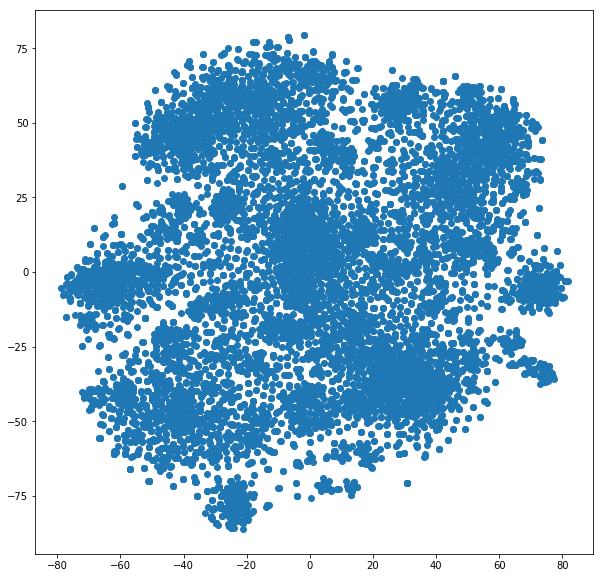

In [27]:
plt.figure(figsize=(10,10))
plt.scatter(reduced_features_glove[:, 0], reduced_features_glove[:, 1])
plt.show()

Similar visualization but with the groups colored:

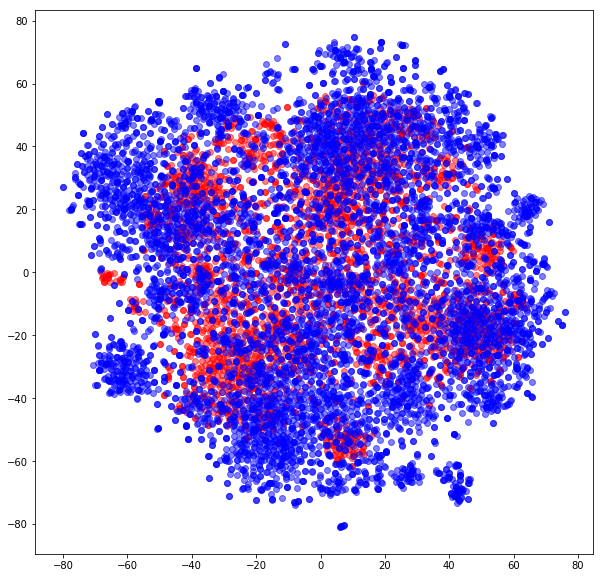

In [28]:
def get_tsne_features(df, label, n_samples = 5):
    label_features = df\
            .query('label_glove == @label')\
            .sample(n_samples)\
            .loc[:, 'glove_embeddings']
    
    label_features = np.stack(label_features.values)
    
    label_features = TSNE(n_components=2).fit_transform(label_features)
    
    return label_features
    
    


group_0 = get_tsne_features(q2_glove_df, 0, n_samples=3000)
group_1 = get_tsne_features(q2_glove_df, 0, n_samples=7000)


plt.figure(figsize=(10, 10))
plt.scatter(group_0[:, 0], group_0[:, 1], color='red', alpha=0.5)
plt.scatter(group_1[:, 0], group_1[:, 1], color = 'blue', alpha=0.5)
plt.show()